# Import Packages

In [52]:
check.packages = function(pkg) {
    new.pkg = pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
}

In [59]:
check.packages(c('RPostgreSQL', 'ggplot2', 'dplyr'))

RPostgreSQL     ggplot2       dplyr 
       TRUE        TRUE        TRUE

In [393]:
options(scipen=999)

# Connect to Database

In [54]:
killDbConnections = function () {
  all_cons = dbListConnections(PostgreSQL())
  print(all_cons)
  for(con in all_cons)
    +  dbDisconnect(con)
  
#   print(paste(length(all_cons), " connections killed."))
}

In [55]:
createReportingConnectionObject = function() {
    
    killDbConnections()
    
    drv = dbDriver('PostgreSQL')

    reporting = dbConnect(
      drv,
      dbname = 'reporting',
      host = 'reporting.ckpglb17yttu.us-east-1.rds.amazonaws.com',
      port = 5432,
      user = Sys.getenv('REPORTING_USER'),
      password = Sys.getenv('REPORTING_PASS')
    )
}

In [56]:
checkReportingConnection = function() {
    
    print(paste(length(dbListConnections(PostgreSQL())), " connections active."))
}

In [263]:
# Do this once Lukass is back and I can set up my own schema that will have [bizops_application_details]

# dbGetQuery(createReportingConnectionObject(),
           
# '
# select
#     id
# from
#     cloudlending.applications
# order by
#     createddate desc
# limit 100
# '
# )

# Import Data

In [728]:
df = read.csv('C:/Users/jchang/Desktop/Projects/Automate FR Meetings/data/dataforbridgeadgrp_2019-1-6_2142.csv')
head(df,5)

grouping,start_date,end_date,adgrp,qualified,attempt_ibv,bankverified,passscorecardratecard,contractsigned,cs_decisioned,funded
P1,2018-11-19,2018-12-16,Credit Karma,7537,6114,5065,3220,2899,2618,1920
P1,2018-11-19,2018-12-16,Credit Sesame,1823,1360,1169,809,590,529,411
P1,2018-11-19,2018-12-16,Direct Mail,11088,8280,7354,5610,4387,3855,3120
P1,2018-11-19,2018-12-16,Email,3399,2498,2113,1524,1236,1064,840
P1,2018-11-19,2018-12-16,Lead Providers,2261,1056,801,579,466,387,265


# Preprocessing Functions

##### Convert to Funnel Name

In [285]:
## THIS REQUIRES QUOTES AROUND THE ARGUMENT!

getFunnelName = function(atStatus_string) {
    
    return_string = ''
    
    if (atStatus_string == 'qualified') {
        return_string = 'Q'
    }
    else if (atStatus_string == 'attempt_ibv') {
        return_string = 'Attempt_IBV'
    }
    else if (atStatus_string == 'bankverified') {
        return_string = 'BV'
    }
    else if (atStatus_string == 'passscorecardratecard') {
        return_string = 'SC'
    }
    else if (atStatus_string == 'contractsigned') {
        return_string = 'CS'
    }
    else if (atStatus_string == 'cs_decisioned') {
        return_string = 'CS_Decisioned'
    }
    else if (atStatus_string == 'funded') {
        return_string = 'F'
    }
    
    return(return_string)
    
}

##### Get the Adgrp Mix [p(i)]

In [ ]:
## We want to pass in a column name of df so that it gets summarized.
## However, there are two problems.
## When we call the function, the argument gets evaluated rather that quoted. We need it quoted.
## When the function is run, the argument gets automatically quoted. We want it done manually.
## So, we want to use quo() in the function call, then !! when the argument is referenced in the function.

In [289]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the denominator for each period.

getMixDenominator = function(denominator) {
    
    total = df %>%
        group_by(grouping) %>%
        summarize(total = sum(!!denominator))

    return(total)
}

In [290]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, and mix at the status specified in the argument.

getMix = function(denominator) {
    
    
    ## First, calculate the total apps for each period.
    total = getMixDenominator(quo(!!denominator))
        
    
    ## Next, attach the denominator to the overall dataset, which is numerators.
    temp_df = merge(
        x = df,
        y = total,
        by.x = 'grouping',
        by.y = 'grouping'
    )
    
    
    ## Next, calculate the mix.
    mix = data.frame(
        temp_df[,'grouping'],
        temp_df[,'adgrp'],
        temp_df[,quo_name(denominator)]/temp_df[,'total']
    )
    
    
    ## Finally, format the data to be returned.
    colnames(mix) = c(
        'grouping',
        'adgrp',
        paste(getFunnelName(quo_name(denominator)),'_mix', sep = '')
    )
    
    mix$grouping = as.character(mix$grouping)
    mix$adgrp = as.character(mix$adgrp)
    
       
    return(mix)
    
}

##### Get the Adgrp Conversion Rate [y(i)]

In [319]:
## THIS REQUIRES QUOTES AROUND EACH ARGUMENT!
## This returns the period, adgrp, and conversion between the statuses specified in the argument.

getConversion = function(numerator, denominator){
    
    conversion = data.frame(
        df[,'grouping'],
        df[,'adgrp'],
        df[,quo_name(numerator)]/df[,quo_name(denominator)]
    )
           
    
    colnames(conversion) = c(
        'grouping',
        'adgrp',
        paste(getFunnelName(numerator),'_',getFunnelName(denominator),sep = '')
    )
    
    return(conversion)
    
}

##### Get the Total Conversion Rate [y_bar]

In [308]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, and conversion between the statuses specified in the argument.

getConversionTotal = function(numerator, denominator){
    
    a = getMixDenominator(quo(!!numerator))
    b = getMixDenominator(quo(!!denominator))
    
    total_conversion = data.frame(
        a$grouping,
        'All',
        1,
        a$total/b$total
    )
    
    colnames(total_conversion) = c(
        'Grouping',
        'Adgrp',
        'Mix',
        paste(getFunnelName(quo_name(numerator)),'/',getFunnelName(quo_name(denominator)),sep = '')        
    )
    
    return(total_conversion)
    
}

##### Get Label Data Needed for ggplot Bridge

In [735]:
## THIS REQUIRES QUOTES AROUND EACH ARGUMENT!
## 

getLabels = function(numerator, denominator) {
    
    conversionName = ''

    if(quo_name(numerator) == 'funded' & quo_name(denominator) == 'qualified') {
        conversionName = 'Funding Rate'
    }
    else {
        conversionName = paste(
            getFunnelName(quo_name(numerator)),
            '/',
            getFunnelName(quo_name(denominator)),
            sep = ''
        )
    }
    
    
    p1_start = df$start_date[which(as.character(df$grouping) == 'P1')]
    p1_end = df$end_date[which(as.character(df$grouping) == 'P1')]
    p2_start = df$start_date[which(as.character(df$grouping) == 'P2')]
    p2_end = df$end_date[which(as.character(df$grouping) == 'P2')]
    
    all_labels = data.frame(
        conversionStep = conversionName,
        p1_start,
        p1_end,
        p2_start,
        p2_end
    )
        
    return(unique(all_labels))
    
}

##### Get Data Frame Needed for ggplot Bridge

In [315]:
## THIS REQUIRES QUO() IN THE ARGUMENT!
## This returns the period, adgrp, mix at the status specified in the argument, and the specified conversion.

getMixConversion = function(numerator, denominator) {

    mix = getMix(denominator = quo(!!denominator))
    conversion = getConversion(numerator = quo_name(numerator), denominator = quo_name(denominator))

    final_adgrp = merge(
        x = mix,
        y = conversion,
        by.x = c('grouping', 'adgrp'),
        by.y = c('grouping', 'adgrp')
    )

    final_all = getConversionTotal(numerator = quo(!!numerator), denominator = quo(!!denominator))
    
    colnames(final_all) = colnames (final_adgrp)

    final = rbind(final_adgrp, final_all)


    return(final)
    
}


In [321]:
getMixConversion(quo(funded), quo(qualified))

grouping,adgrp,Q_mix,F_Q
P1,Credit Karma,0.126981720,0.2547433
P1,Credit Sesame,0.030713503,0.2254526
P1,Direct Mail,0.186808188,0.2813853
P1,Email,0.057265605,0.2471315
P1,Lead Providers,0.038092831,0.1172048
P1,Lending Tree,0.135270828,0.2317848
P1,New Initiatives,0.025204279,0.2573529
P1,Other,0.010732036,0.2025118
P1,Other Partners,0.204717378,0.1915069
P1,Referral,0.041260214,0.3854635


##### Reformat Data Frame Needed for ggplot Bridge

In [331]:
getMixConversionReformat = function(numerator, denominator) {
    
    preformat = getMixConversion(quo(!!numerator), quo(!!denominator))
    
    reformat = data.frame(
        adgrp = preformat$adgrp[which(preformat$grouping == 'P1')],
        p0 = preformat$Q_mix[which(preformat$grouping == 'P1')],
        p1 = preformat$Q_mix[which(preformat$grouping == 'P2')],
        y0 = preformat$F_Q[which(preformat$grouping == 'P1')],
        y1 = preformat$F_Q[which(preformat$grouping == 'P2')],
        ybar = preformat$F_Q[which(preformat$grouping == 'P1' & preformat$adgrp == 'All')]
        
    )
    
    return(reformat)
    
}

In [333]:
a = getMixConversionReformat(quo(funded), quo(qualified))
a

adgrp,p0,p1,y0,y1,ybar
Credit Karma,0.12698172,0.114757758,0.2547433,0.2594034,0.2406537
Credit Sesame,0.03071350,0.029173179,0.2254526,0.2219388,0.2406537
Direct Mail,0.18680819,0.130683932,0.2813853,0.3251708,0.2406537
Email,0.05726561,0.072188733,0.2471315,0.2515464,0.2406537
Lead Providers,0.03809283,0.032150033,0.1172048,0.1574074,0.2406537
Lending Tree,0.13527083,0.154573193,0.2317848,0.2185845,0.2406537
New Initiatives,0.02520428,0.027610330,0.2573529,0.2156334,0.2406537
Other,0.01073204,0.008260772,0.2025118,0.1981982,0.2406537
Other Partners,0.20471738,0.216715041,0.1915069,0.1813187,0.2406537
Referral,0.04126021,0.052094962,0.3854635,0.3642857,0.2406537


# Create ggplot Bridge

In [ ]:
## One chart will have the the long bridge.
## One chart will have the deltas, split by color impact.
## One chart will have the deltas due to mix, another due to conversion.

In [ ]:
## Set numerator and denominator.

numerator = 

In [738]:
## Run function to get necessary labels for the bridge.

df_labels = getLabels(quo(funded), quo(qualified))
df_labels

conversionStep,p1_start,p1_end,p2_start,p2_end
Funding Rate,2018-11-19,2018-12-16,2018-12-17,2018-12-23


In [556]:
## Run function to get necessary parameters to build the bridge.

df_pull = getMixConversionReformat(quo(funded), quo(qualified))
df_pull

adgrp,p0,p1,y0,y1,ybar
Credit Karma,0.12698172,0.114757758,0.2547433,0.2594034,0.2406537
Credit Sesame,0.03071350,0.029173179,0.2254526,0.2219388,0.2406537
Direct Mail,0.18680819,0.130683932,0.2813853,0.3251708,0.2406537
Email,0.05726561,0.072188733,0.2471315,0.2515464,0.2406537
Lead Providers,0.03809283,0.032150033,0.1172048,0.1574074,0.2406537
Lending Tree,0.13527083,0.154573193,0.2317848,0.2185845,0.2406537
New Initiatives,0.02520428,0.027610330,0.2573529,0.2156334,0.2406537
Other,0.01073204,0.008260772,0.2025118,0.1981982,0.2406537
Other Partners,0.20471738,0.216715041,0.1915069,0.1813187,0.2406537
Referral,0.04126021,0.052094962,0.3854635,0.3642857,0.2406537


In [696]:
## First, calculate the mix and conversion impacts of each adgrp, and labeled as such.

df_bridge = data.frame(
    type = c(rep('2Mix', nrow(df_pull)), rep('4Conversion', nrow(df_pull))),
    adgrp = rep(df_pull$adgrp, 2),
    value = c(df_pull$y0 * (df_pull$p1-df_pull$p0),df_pull$p1 * (df_pull$y1-df_pull$y0))
)
df_bridge = df_bridge[which(df_bridge$adgrp != 'All'),]

df_bridge$adgrp = paste(substr(df_bridge$type,1,1), df_bridge$adgrp, sep = '')

# df_bridge$adgrp = ifelse(
#     as.numeric(substr(df_bridge$type,1,1)) == 2,
#     paste('Mix_', df_bridge$adgrp, sep = ''),
#     paste('Conversion_', df_bridge$adgrp, sep = '')
# )

df_bridge

,type,adgrp,value
1,2Mix,2Credit Karma,-0.00311397194
2,2Mix,2Credit Sesame,-0.00034727019
3,2Mix,2Direct Mail,-0.01579253945
4,2Mix,2Email,0.00368797498
5,2Mix,2Lead Providers,-0.00069652429
6,2Mix,2Lending Tree,0.00447399451
7,2Mix,2New Initiatives,0.00061920413
8,2Mix,2Other,-0.00050045997
9,2Mix,2Other Partners,0.00229763473
10,2Mix,2Referral,0.00417639928


In [714]:
## Second, calculate the Previous, Mix Checkpoint, and Current conversion rates.

df_all = data.frame(
    type = c('1Previous','3PostMix','5Current'),
    adgrp = c('Previous','PostMix','Current'),
#     adgrp = rep('All',3),
    value = c(df_pull$y0[which(df_pull$adgrp == 'All')],
              df_pull$y0[which(df_pull$adgrp == 'All')] + sum(df_bridge$value[which(df_bridge$type == '2Mix')]),
              df_pull$y1[which(df_pull$adgrp == 'All')]                 
             )
)
df_all$adgrp = paste(substr(df_all$type,1,1), df_all$adgrp, sep = '')

df_all

type,adgrp,value
1Previous,1Previous,0.2406537
3PostMix,3PostMix,0.2400807
5Current,5Current,0.2405299


In [715]:
## Third, combine the two above data frames, and assign a color.

df_bridge_combined = rbind(
    df_bridge,
    df_all
)

df_bridge_combined = data.frame(
    df_bridge_combined,
#     color = rep('colored', nrow(df_bridge_combined))
    color = ifelse(
        as.numeric(substr(df_bridge_combined$type,1,1)) %in% c(1,3,5),
        'blue',
        ifelse(
            df_bridge_combined$value >= 0,
            'green',
            'red'
        )
    )
)

df_bridge_combined$type = as.character(df_bridge_combined$type)
df_bridge_combined$adgrp = as.character(df_bridge_combined$adgrp)

df_bridge_combined

,type,adgrp,value,color
1,2Mix,2Credit Karma,-0.00311397194,red
2,2Mix,2Credit Sesame,-0.00034727019,red
3,2Mix,2Direct Mail,-0.01579253945,red
4,2Mix,2Email,0.00368797498,green
5,2Mix,2Lead Providers,-0.00069652429,red
6,2Mix,2Lending Tree,0.00447399451,green
7,2Mix,2New Initiatives,0.00061920413,green
8,2Mix,2Other,-0.00050045997,red
9,2Mix,2Other Partners,0.00229763473,green
10,2Mix,2Referral,0.00417639928,green


In [716]:
## Fourth, sort the Mix and Conversion impacts in descending order.

df_colored = rbind(
    df_bridge_combined[which(df_bridge_combined$type == '1Previous'),],
df_bridge_combined[which(df_bridge_combined$type == '2Mix'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
    df_bridge_combined[which(df_bridge_combined$type == '3PostMix'),],
    df_bridge_combined[which(df_bridge_combined$type == '4Conversion'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
    df_bridge_combined[which(df_bridge_combined$type == '5Current'),]
)
rownames(df_colored) = seq(1:nrow(df_colored))

df_colored

type,adgrp,value,color
1Previous,1Previous,0.24065369388,blue
2Mix,2SEO,0.00462251867,green
2Mix,2Lending Tree,0.00447399451,green
2Mix,2Referral,0.00417639928,green
2Mix,2Email,0.00368797498,green
2Mix,2Other Partners,0.00229763473,green
2Mix,2New Initiatives,0.00061920413,green
2Mix,2Credit Sesame,-0.00034727019,red
2Mix,2Other,-0.00050045997,red
2Mix,2Lead Providers,-0.00069652429,red


In [717]:
# df_bridge = data.frame(
#     type = c(rep('2Mix', nrow(df_pull)), rep('4Conversion', nrow(df_pull))),
#     adgrp = rep(df_pull$adgrp, 2),
#     value = c(df_pull$y0 * (df_pull$p1-df_pull$p0),df_pull$p1 * (df_pull$y1-df_pull$y0))
# )
# df_bridge = df_bridge[which(df_bridge$adgrp != 'All'),]

# df_all = data.frame(
#     type = c('1Previous','3PostMix','5Current'),
#     adgrp = c('Previous','PostMix','Current'),
# #     adgrp = rep('All',3),
#     value = c(df_pull$y0[which(df_pull$adgrp == 'All')],
#               df_pull$y0[which(df_pull$adgrp == 'All')] + sum(df_bridge$value[which(df_bridge$type == '2Mix')]),
#               df_pull$y1[which(df_pull$adgrp == 'All')]                 
#              )
# )

# # sort by ordering asc, value desc
# df_bridge_combined = rbind(
#     df_bridge,
#     df_all
# )

# df_bridge_combined = data.frame(
#     df_bridge_combined,
# #     color = rep('colored', nrow(df_bridge_combined))
#     color = ifelse(
#         as.numeric(substr(df_bridge_combined$type,1,1)) %in% c(1,3,5),
#         'blue',
#         ifelse(
#             df_bridge_combined$value >= 0,
#             'green',
#             'red'
#         )
#     )
# )

# df_bridge_combined$type = as.character(df_bridge_combined$type)
# df_bridge_combined$adgrp = as.character(df_bridge_combined$adgrp)

# # df_bridge_combined

# df_colored = rbind(
#     df_bridge_combined[which(df_bridge_combined$type == '1Previous'),],
# df_bridge_combined[which(df_bridge_combined$type == '2Mix'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '2Mix')])),],
#     df_bridge_combined[which(df_bridge_combined$type == '3PostMix'),],
#     df_bridge_combined[which(df_bridge_combined$type == '4Conversion'),][rev(order(df_bridge_combined$value[which(df_bridge_combined$type == '4Conversion')])),],
#     df_bridge_combined[which(df_bridge_combined$type == '5Current'),]
# )
# rownames(df_colored) = seq(1:nrow(df_colored))


# # df_colored = df_bridge_combined[order(df_colored$type, df_colored$value),]
# # data.frame(
# #     rownames = rownames(df_colored),
# #     df_colored
# # )
# df_colored

In [718]:
## Fifth, calculate the whitespace that must pad the bridge values.

white = c(
    0,
    df_colored$value[which(df_colored$type == '1Previous')] + 
        cumsum(df_colored$value[which(df_colored$type == '2Mix')]) -
        ifelse(df_colored$value[which(df_colored$type == '2Mix')] > 0,
               df_colored$value[which(df_colored$type == '2Mix')],
               0),
    0,
    df_colored$value[which(df_colored$type == '3PostMix')] + 
        cumsum(df_colored$value[which(df_colored$type == '4Conversion')]) -
        ifelse(df_colored$value[which(df_colored$type == '4Conversion')] > 0,
               df_colored$value[which(df_colored$type == '4Conversion')],
               0),
    0
)

df_whitespace = data.frame(
    type = df_colored$type,
    adgrp = df_colored$adgrp,
    value = white,
    color = rep('white', nrow(df_colored))
)

df_whitespace

type,adgrp,value,color
1Previous,1Previous,0.0000000,white
2Mix,2SEO,0.2406537,white
2Mix,2Lending Tree,0.2452762,white
2Mix,2Referral,0.2497502,white
2Mix,2Email,0.2539266,white
2Mix,2Other Partners,0.2576146,white
2Mix,2New Initiatives,0.2599122,white
2Mix,2Credit Sesame,0.2601842,white
2Mix,2Other,0.2596837,white
2Mix,2Lead Providers,0.2589872,white


In [769]:
## Finally, append the two data frames.
## We need to convert the x axis (adgrps) back to factors from strings in order to preserve the sort order we want.
## Since df_dinal$adgrp is non-unique, we must pass a vector with no duplicate values as part of this process.

## Value must be reformatted into Value_label and Value_bar.
## This is to ensure that the white space is below the colored portion, while allowing accurate data labels.

df_appended = rbind(
    df_colored,
    df_whitespace
)

df_appended$adgrp = factor(df_appended$adgrp, levels = unique(df_appended$adgrp))

# df_appended

df_final = data.frame(
    df_appended,
    value_bar = abs(df_appended$value),
    value_label = ifelse(
        as.character(df_appended$color) != 'white',
        ifelse(
            as.numeric(substr(df_appended$type,1,1)) %in% c(1,3,5),
            paste(round(df_appended$value*100,2), '%', sep = ''),
            paste(round(df_appended$value*10000,0))
        ),
        ''
    )
)

df_final

type,adgrp,value,color,value_bar,value_label
1Previous,1Previous,0.24065369388,blue,0.24065369388,24.07%
2Mix,2SEO,0.00462251867,green,0.00462251867,46
2Mix,2Lending Tree,0.00447399451,green,0.00447399451,45
2Mix,2Referral,0.00417639928,green,0.00417639928,42
2Mix,2Email,0.00368797498,green,0.00368797498,37
2Mix,2Other Partners,0.00229763473,green,0.00229763473,23
2Mix,2New Initiatives,0.00061920413,green,0.00061920413,6
2Mix,2Credit Sesame,-0.00034727019,red,0.00034727019,-3
2Mix,2Other,-0.00050045997,red,0.00050045997,-5
2Mix,2Lead Providers,-0.00069652429,red,0.00069652429,-7


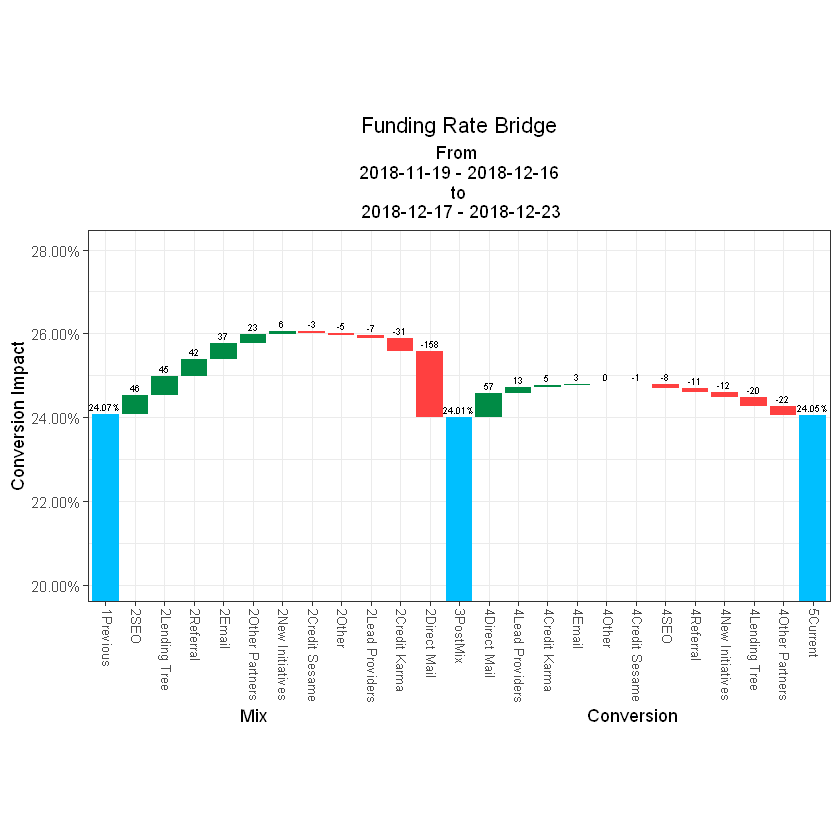

In [777]:
###### Finally, create the bridge.
## First, set the theme.
## Second, call ggplot(). We pass in value_bar, which are all positive values, to ensure that white bars stay on bottom.
## Color will control fill and transparency (alpha).

theme_set(theme_bw())

ggplot(
    data = df_final,
    mapping = aes(
        x = adgrp,
        y = value_bar,
        fill = color,
        alpha = color
    )
) +
geom_col() +
scale_fill_manual(
    'legend',
    values = c(
        'red' = 'brown1',
        'green' = 'springgreen4',
        'blue' = 'deepskyblue',
        'white' = 'white'
    )
) +
scale_alpha_manual(
    values = c(
        'blue' = 1,
        'green' = 1,
        'red' = 1,
        'white' = 0
    )
) +
scale_y_continuous(
    labels = scales::percent
) +
coord_cartesian(
    ylim = c(
        min(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) - 0.04,
        max(df_final$value[which(substr(df_final$type,1,1) %in% c(1,3,5) & as.character(df_final$color) != 'white')]) + 0.04
    )
) +
geom_text(
    aes(label = value_label),
    position = 'stack',
    vjust = -0.5,
    hjust = 0.5,
    size = 2
) +
labs(
    x = 'Mix                                                                Conversion',
    y = 'Conversion Impact',
    title = paste(df_labels$conversionStep, 'Bridge'),
    subtitle = paste(
        'From \n',
        df_labels$p1_start, '-', df_labels$p1_end,
        '\n to \n',
        df_labels$p2_start, '-', df_labels$p2_end
    )
) +
theme(
    plot.title = element_text(
        hjust = 0.5
    ),
    plot.subtitle = element_text(
        hjust = 0.5
    ),
    axis.title.x = element_text(
        hjust = 0.5
    ),
    axis.text.x = element_text(
        angle = 270,
        size = 8,
        vjust = 0.25,
        hjust = 0
    ),
    legend.position = "none",
    aspect.ratio = 1/2
)



In [639]:
?scale_x_continuous

In [655]:
?theme

### Old bridge example

In [530]:
ggplot(data = df2, mapping = aes(x = levers2, 
                                 y = values, 
                                 fill = color2, 
                                 alpha = color2)) + 
    geom_col() + 
    scale_fill_manual("legend", values = c("white" = "white", 
                                           "blue" = "deepskyblue", 
                                           "red" = "brown1", 
                                           "green" = "springgreen4", 
                                           "orange" = "deepskyblue3")) + 
    scale_alpha_manual(values = c("white" = 0, 
                                  "blue" = 1, 
                                  "red" = 1, 
                                  "green" = 1, 
                                  "orange" = "1")) + 
    scale_y_continuous(labels = scales::percent) + 
    geom_text(aes(label = values_format), position = "stack", vjust = -0.5) + 
    labs(x = "Levers", y = "%Q", title = paste("Funding Rate Bridge - Levers", 
                                               "\n", 
                                               "From ", 
                                               df$startdate[which(df$period == "P1")], 
                                               " to ", 
                                               df$enddate[which(df$period == "P1")], 
                                               "\n", 
                                               "Through ", 
                                               df$startdate[which(df$period == "P2")], 
                                               " to ", 
                                               df$enddate[which(df$period == "P2")])) + 
    theme(plot.title = element_text(hjust = 0.5), legend.position = "none")

periscope.image()

ERROR: Error in ggplot(data = df2, mapping = aes(x = levers2, y = values, fill = color2, : object 'df2' not found


In [342]:
library(ggplot2)

levers = c(
    "1Previous FR", 
    "2BV/Q", 
    "3Pass Scorecard", 
    "4Contract Signed", 
    "5Decisioned", 
    "6Funded/Decisioned", 
    "7New FR"
)

bridge = c(
    df$fundingrate[which(df$period == "P1")], 
    (df$bvq[which(df$period == "P2")]-df$bvq[which(df$period == "P1")])*prod(df[which(df$period == "P1"),4:7]), 
    (df$scorecardbv[which(df$period == "P2")]-df$scorecardbv[which(df$period == "P1")])*prod(df[which(df$period == "P1"),5:7])*prod(df[which(df$period == "P2"),3]), 
    (df$contractscorecard[which(df$period == "P2")]-df$contractscorecard[which(df$period == "P1")])*prod(df[which(df$period == "P1"),6:7])*prod(df[which(df$period == "P2"),3:4]), 
    (df$decisionedcontract[which(df$period == "P2")]-df$decisionedcontract[which(df$period == "P1")])*prod(df[which(df$period == "P1"),7])*prod(df[which(df$period == "P2"),3:5]), 
    (df$fundeddecisioned[which(df$period == "P2")]-df$fundeddecisioned[which(df$period == "P1")])*prod(df[which(df$period == "P2"),3:6]), 
    df$fundingrate[which(df$period == "P2")]
)

whitespace = c(
    0, 
    ifelse(bridge[2] >= 0, sum(bridge[1:1]), sum(bridge[1:2])), 
    ifelse(bridge[3] >= 0, sum(bridge[1:2]), sum(bridge[1:3])), 
    ifelse(bridge[4] >= 0, sum(bridge[1:3]), sum(bridge[1:4])), 
    ifelse(bridge[5] >= 0, sum(bridge[1:4]), sum(bridge[1:5])), 
    ifelse(bridge[6] >= 0, sum(bridge[1:5]), sum(bridge[1:6])), 
    0
)

color = c(
    "orange", 
    ifelse(bridge[2] >= 0, "green", "red"), 
    ifelse(bridge[3] >= 0, "green", "red"), 
    ifelse(bridge[4] >= 0, "green", "red"), 
    ifelse(bridge[5] >= 0, "green", "red"), 
    ifelse(bridge[6] >= 0, "green", "red"), 
    "blue"
)

levers2 = rep(levers,2)
values = c(whitespace, abs(bridge))
category = c(rep("whitespace",7), rep("bridge",7))
color2 = c(rep("white",7), color)
values_format = c(rep("",length(levers)), paste(round(100*bridge, 2), '%', sep = ""))

df2 = data.frame(
    levers2, 
    values, 
    category, 
    color2, 
    values_format
)

ggplot(data = df2, mapping = aes(x = levers2, 
                                 y = values, 
                                 fill = color2, 
                                 alpha = color2)) + 
    geom_col() + 
    scale_fill_manual("legend", values = c("white" = "white", 
                                           "blue" = "deepskyblue", 
                                           "red" = "brown1", 
                                           "green" = "springgreen4", 
                                           "orange" = "deepskyblue3")) + 
    scale_alpha_manual(values = c("white" = 0, 
                                  "blue" = 1, 
                                  "red" = 1, 
                                  "green" = 1, 
                                  "orange" = "1")) + 
    scale_y_continuous(labels = scales::percent) + 
    geom_text(aes(label = values_format), position = "stack", vjust = -0.5) + 
    labs(x = "Levers", y = "%Q", title = paste("Funding Rate Bridge - Levers", 
                                               "\n", 
                                               "From ", 
                                               df$startdate[which(df$period == "P1")], 
                                               " to ", 
                                               df$enddate[which(df$period == "P1")], 
                                               "\n", 
                                               "Through ", 
                                               df$startdate[which(df$period == "P2")], 
                                               " to ", 
                                               df$enddate[which(df$period == "P2")])) + 
    theme(plot.title = element_text(hjust = 0.5), legend.position = "none")

periscope.image()

ERROR: Error in FUN(X[[i]], ...): only defined on a data frame with all numeric variables
